In [1]:
import os
import pickle
import napari
import nd2
import numpy as np
from skimage.draw import polygon
from skimage.io import imsave

from cardiomyocytes_helper_functions import fill_gaps_between_cells 

In [2]:
path_dir = r'D:\data_analysis\2022_Sahana\data\Collagen\60x images'
im_name = r'092622_ring_PDMSAp_10MCol_647-Act_561-Pax_488-Plak_DAPI_001.nd2'
path_im = os.path.join(path_dir,im_name)

path_save = r'D:\data_analysis\2022_Sahana\masks'

In [3]:
im = nd2.imread(path_im)

In [4]:
im.shape

(27, 4, 512, 512)

In [5]:
# create a maximum projection

actin_max = np.max(im[:,0,:,:],axis=0)

In [6]:
viewer = napari.Viewer()
viewer.add_image(im[:,0,:,:],colormap='magenta',blending='additive')
viewer.add_image(im[:,1,:,:],colormap='red',blending='additive')
viewer.add_image(im[:,2,:,:],colormap='green',blending='additive')
viewer.add_image(im[:,3,:,:],colormap='blue',blending='additive')
viewer.add_image(actin_max,blending='additive')

Assistant skips harvesting pyclesperanto as it's not installed.


<Image layer 'actin_max' at 0x23b79fa2fa0>

## Manually draw shapes

In [7]:
# Manually define cells 

pkl_path = os.path.join(path_save,im_name.replace('.nd2','_polygons.pkl'))

if os.path.exists(pkl_path):

    # open existing mask
    with open(pkl_path, 'rb') as f:
        vertices_polygons = pickle.load(f)

    viewer.add_shapes(vertices_polygons, shape_type='polygon',name='Shapes')

else:
    viewer.add_shapes()


c:\Users\lab\.conda\envs\napari-env\lib\site-packages\numpy\core\numeric.py:2463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


Use the set of tools available in Napari to draw the contours of the cells. Do not include cells that are not complete.

## Correction of shapes

In [8]:
# get coordinates of vertices
vertices_polygons = viewer.layers['Shapes'].data
len(vertices_polygons)

4

In [34]:
# create a mask out of vertices
mask = np.zeros(im.shape[2:]).astype('uint8')

for i,poly in enumerate(vertices_polygons):

    # if drawing was in 3D
    if len(poly.shape) > 2:
        mask_coord = polygon(vertices_polygons[i][:,1],vertices_polygons[i][:,2],shape=im.shape[2:])
    else:
        mask_coord = polygon(vertices_polygons[i][:,0],vertices_polygons[i][:,1],shape=im.shape[2:])

    mask[mask_coord] = mask[mask_coord] + (i+1)

    # mark areas of the overlap
    mask[mask > (i+1)] = 255

mask_shapes_overlap = mask

# shapes without overlapping regions
mask_shapes = mask_shapes_overlap.copy()
mask_shapes[mask_shapes == 255] = 0

In [35]:
viewer.add_labels(mask_shapes_overlap,name = 'Masks')

<Labels layer 'Masks' at 0x23b02e083a0>

In [36]:
im_divided = fill_gaps_between_cells(mask_shapes_overlap)

In [37]:
masks_corrected = mask_shapes + im_divided
viewer.add_labels(masks_corrected)

<Labels layer 'masks_corrected' at 0x23b02f20fd0>

In [23]:
from skimage.measure import find_contours, approximate_polygon
import matplotlib.pyplot as plt

In [24]:
# Corrected shapes

contours = find_contours(mask_shapes)

In [33]:
contours[0]

array([[287.5, 184. ],
       [287.5, 183. ],
       [287.5, 182. ],
       ...,
       [286.5, 185. ],
       [287. , 184.5],
       [287.5, 184. ]])

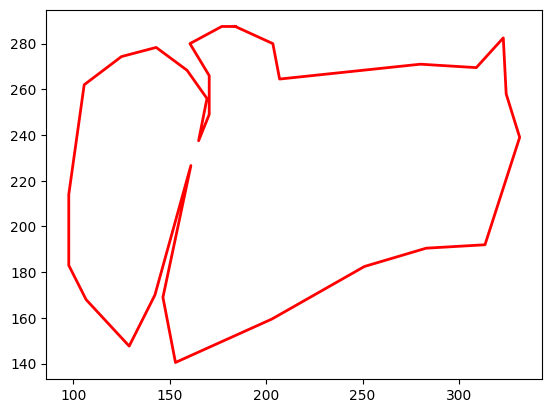

In [28]:
fig,ax = plt.subplots(1)

for contour in contours:

    coords = approximate_polygon(contour, tolerance=2)
    ax.plot(coords[:, 1], coords[:, 0], '-r', linewidth=2)

    break

## Save shapes

In [11]:
# saving
mask_path = os.path.join(path_save,im_name.replace('.nd2','_mask.png'))
imsave(mask_path,mask)


pkl_path = os.path.join(path_save,im_name.replace('.nd2','_polygons.pkl'))
with open(pkl_path, 'wb') as f:
    pickle.dump(vertices_polygons, f)

C:\Users\lab\AppData\Local\Temp\ipykernel_27976\2345319060.py:3: UserWarning: D:\data_analysis\2022_Sahana\masks\092622_ring_PDMSAp_10MCol_647-Act_561-Pax_488-Plak_DAPI_001_mask.png is a low contrast image
  imsave(mask_path,mask)
